In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
import xgboost as xgb

In [41]:
import warnings
warnings.filterwarnings('ignore')

In [42]:
data='Fraud1.csv'
df=pd.read_csv(data)

In [43]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# 1. Data cleaning including missing values, outliers and multi-collinearity.


In [44]:
#Missing Values
df.isnull().sum()


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

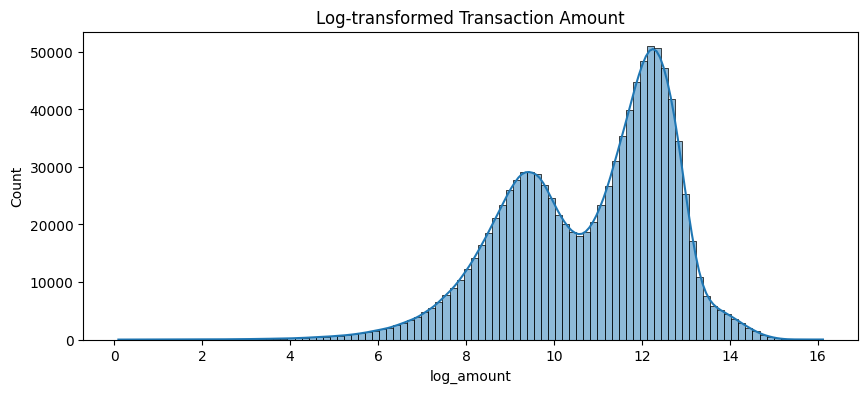

In [45]:
#Handel Outliers
df['log_amount'] = np.log1p(df['amount'])
plt.figure(figsize=(10, 4))
sns.histplot(df['log_amount'], bins=100, kde=True)
plt.title("Log-transformed Transaction Amount")
plt.show()

In [46]:
#Multicollinearity Check
#derived features to reduce multicollinearity
df['deltaOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['deltaDest'] = df['newbalanceDest'] - df['oldbalanceDest']

In [47]:
df['deltaOrig']

0            9839.64
1            1864.28
2             181.00
3             181.00
4           11668.14
             ...    
1048570    132557.35
1048571      9917.36
1048572     14140.05
1048573     10020.05
1048574     11450.03
Name: deltaOrig, Length: 1048575, dtype: float64

In [48]:
df['deltaDest']

0               0.00
1               0.00
2               0.00
3          -21182.00
4               0.00
             ...    
1048570    132557.35
1048571         0.00
1048572         0.00
1048573         0.00
1048574         0.00
Name: deltaDest, Length: 1048575, dtype: float64

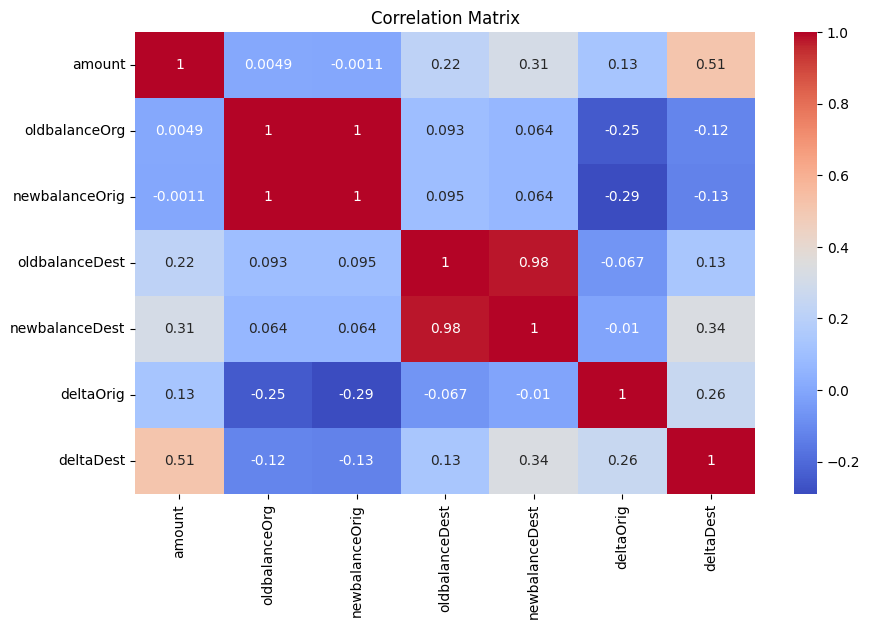

In [49]:
numeric_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 
                'oldbalanceDest', 'newbalanceDest', 'deltaOrig', 'deltaDest']

plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# 2. Describe your fraud detection model in elaboration.


In [50]:
#Filter only relevant transaction types
# Keep only rows where either type_TRANSFER or type_CASH_OUT is 
df = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])]

In [51]:
Create useful features
df['deltaOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['deltaDest'] = df['newbalanceDest'] - df['oldbalanceDest']

SyntaxError: invalid syntax (1559975811.py, line 1)

In [ ]:
#Drop Unwanted Column
df_model = df[['amount', 'deltaOrig', 'deltaDest', 'type', 'isFraud']]
df_model = pd.get_dummies(df_model, columns=['type'], drop_first=True)

In [ ]:
# Features and Target
X = df_model.drop('isFraud', axis=1)
y = df_model['isFraud']

In [ ]:
Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Step 4: Train XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

In [ ]:
# Step 5: Predict and evaluate
y_pred = model.predict(X_test)

In [ ]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 3.How did you select variables to be included in the model?


In [ ]:
# Create delta features
df['deltaOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['deltaDest'] = df['newbalanceDest'] - df['oldbalanceDest']

# Keep relevant columns only
df_model = df[['amount', 'deltaOrig', 'deltaDest', 'type', 'isFraud']]
df_model = pd.get_dummies(df_model, columns=['type'], drop_first=True)  # one-hot encode type


# Q4: Demonstrate the performance of the model using best set of tools

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)


In [ ]:
# Predict probabilities for ROC
y_proba = model.predict_proba(X_test)[:, 1]  # probability for class 1 (fraud)

# Basic metrics
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("Precision:", round(precision_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# Q5: What are the key factors that predict fraudulent customers?

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the model
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for easy sorting and plotting
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the DataFrame
print(feat_imp_df)

# Plot the top features
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Feature Importance from XGBoost Model')
plt.tight_layout()
plt.show()


# Q6: Do these factors make sense? If yes, how? If not, how not?

In [ ]:
#verify the feature make sense

# Separate fraud and non-fraud for comparison
fraud = df[df['isFraud'] == 1]
non_fraud = df[df['isFraud'] == 0]

# Compare average values
print("Mean Values Comparison:\n")
print(f"Amount - Fraud: {fraud['amount'].mean():,.2f}, Non-Fraud: {non_fraud['amount'].mean():,.2f}")
print(f"deltaOrig - Fraud: {fraud['deltaOrig'].mean():,.2f}, Non-Fraud: {non_fraud['deltaOrig'].mean():,.2f}")
print(f"deltaDest - Fraud: {fraud['deltaDest'].mean():,.2f}, Non-Fraud: {non_fraud['deltaDest'].mean():,.2f}")

# Plot distributions
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
sns.kdeplot(fraud['amount'], label='Fraud', fill=True)
sns.kdeplot(non_fraud['amount'], label='Non-Fraud', fill=True)
plt.title('Transaction Amount Distribution')
plt.legend()

plt.subplot(1, 3, 2)
sns.kdeplot(fraud['deltaOrig'], label='Fraud', fill=True)
sns.kdeplot(non_fraud['deltaOrig'], label='Non-Fraud', fill=True)
plt.title('deltaOrig Distribution')
plt.legend()

plt.subplot(1, 3, 3)
sns.kdeplot(fraud['deltaDest'], label='Fraud', fill=True)
sns.kdeplot(non_fraud['deltaDest'], label='Non-Fraud', fill=True)
plt.title('deltaDest Distribution')
plt.legend()

plt.tight_layout()
plt.show()

# Transfer type fraud rate
fraud_transfer_rate = df[df['type'] == 'TRANSFER']['isFraud'].mean()
fraud_cashout_rate = df[df['type'] == 'CASH_OUT']['isFraud'].mean()
print(f"\nFraud Rate in TRANSFER transactions: {fraud_transfer_rate:.4f}")
print(f"Fraud Rate in CASH_OUT transactions: {fraud_cashout_rate:.4f}")


#Feature     #Why It Makes Sense                                                                            
#amount       : Fraudsters target large sums. Fraud transactions usually involve higher amounts.              
#deltaOrig    : Measures how much was removed from sender. A big drop indicates suspicious withdrawal.        
#deltaDest    : Measures how much was added to receiver. Big jumps indicate fraud.                      
#type_TRANSFER: Almost all frauds happen during TRANSFER and CASH_OUT.'



# Q7: What kind of prevention should be adopted while the company updates its infrastructure?

In [ ]:
#Prevention Strategies Let example
df['flag_high_value'] = df['amount'] > 200000
# how many of these were actually fraud
flagged = df[df['flag_high_value']]
fraud_rate_flagged = flagged['isFraud'].mean()
print(f"Flagged high-value transactions: {len(flagged)}")
print(f"Fraud rate among them: {fraud_rate_flagged:.4f}")

In [ ]:
#Flag risky transaction types (TRANSFER & CASH_OUT)

df['flag_risky_type'] = df['type'].isin(['TRANSFER', 'CASH_OUT'])
risky = df[df['flag_risky_type']]
print(f"Fraud rate in risky types: {risky['isFraud'].mean():.4f}")

# Q8: Assuming these actions have been implemented, how would you determine if they worked?

In [ ]:
#To evaluate if fraud prevention actions actually reduced fraud and improved detection.

In [ ]:
#Compare fraud rate before and after a policy change

before = df[df['step'] < 500]
after = df[df['step'] >= 500]

print("Fraud rate before:", before['isFraud'].mean())
print("Fraud rate after:", after['isFraud'].mean())